<a href="https://colab.research.google.com/github/AAhmadS/NLP-HW3/blob/main/NLP_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/TasnimDataset/

/content/drive/.shortcut-targets-by-id/1WC54iNX9iiUwBMeH0jXlgq2JSuERNvwm/TasnimDataset


In [3]:
!pip install dill==0.3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
%%capture
!pip install transformers==4.0.1
! pip install ftfy regex tqdm
! pip install arabic-reshaper
! pip install python-bidi
! pip install dadmatools
!pip install -Uq g2p_en

In [5]:
from __future__ import unicode_literals
# from hazm import Normalizer as hNormalizer
from dadmatools.models.normalizer import Normalizer as dNormalizer
import gc
import time
import copy
import PIL
import torch
import os
import dill
import requests
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn as nn
import multiprocessing
from tqdm import tqdm
from io import BytesIO
import matplotlib.pyplot as plt
from pkg_resources import packaging
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib.font_manager import FontProperties
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from torch.cuda.amp import autocast
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer, AutoModel, TFAutoModel, AutoConfig
from transformers import EncoderDecoderModel
from transformers import GPT2LMHeadModel, GPT2Config
from transformers import BertGenerationConfig, BertGenerationEncoder
from transformers import BertModel
from transformers import TrainingArguments, Trainer, RobertaModel
from transformers import default_data_collator
from IPython.display import clear_output
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import tqdm
import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelWithLMHead
from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Config

from IPython import display

# persian_font = FontProperties(fname='/content/fonts/Vazirmatn-Regular.ttf')
# 
print("Torch version:", torch.__version__)

Torch version: 2.0.1+cu118


<ipython-input-5-6bc956d93c61>:37: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [6]:
!pip install -Uq hazm

import hazm
normalizer = hazm.Normalizer(persian_numbers=False)

def normalize_input(text):
  text = noramlizer.normalize(text)
  return text

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


**So basically we are going to train an encoder-decoder model based on our natural language data to have good enough text encoder and general decoder, next step is to bring on the vision model and connect the vision encoder to the trained decoder, now the decoder part is going to freeze and the vision encoder is going to learn the latent space pretty well**

## Defining the ML-Model

###Loading the models

**First we should manage to train our nlp enc-dec model, we've chosen Parsebert and ParsGPT for the task**

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [8]:
##loading the gpt and bert model
gpt_name_or_path = "HooshvareLab/gpt2-fa"
bert_name_or_path = "HooshvareLab/bert-fa-base-uncased-clf-persiannews"
##we wil stick to gpt tokenizer as our chosen tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    gpt_name_or_path,
    bos_token='<s>', 
    eos_token='</s>', 
    pad_token='<pad>',
    unk_token='<unk>'
)
tokenizer.add_special_tokens({
    "bos_token": '</s>',
    "eos_token": '</s>', 
    "pad_token": '<pad>',
    "unk_token": '<unk>'
})

config = AutoConfig.from_pretrained(
    gpt_name_or_path,
    bos_token_id=tokenizer("<s>")["input_ids"][0], 
    eos_token_id=tokenizer("</s>")["input_ids"][0], 
    pad_token_id=tokenizer("<pad>")["input_ids"][0],
    unk_token_id=tokenizer("<unk>")["input_ids"][0],
)

bert_config = AutoConfig.from_pretrained(bert_name_or_path)

##saving the config on the drive
tokenizer.save_pretrained("/content/gpt2/")
config.save_pretrained("/content/gpt2/")
bert_config.save_pretrained("/content/bert/")

!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin" -P /content/gpt2/
!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/tokenizer.json" -P /content/gpt2/
!wget "https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews/resolve/main/pytorch_model.bin" -p /content/bert/

--2023-06-06 02:21:18--  https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 18.67.0.90, 18.67.0.34, 18.67.0.67, ...
Connecting to huggingface.co (huggingface.co)|18.67.0.90|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/HooshvareLab/gpt2-fa/46b0b806c740a0f0a9f056f5574c5fa896166fe844945fd3c849bf34365e5060?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1686277279&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL0hvb3NodmFyZUxhYi9ncHQyLWZhLzQ2YjBiODA2Yzc0MGEwZjBhOWYwNTZmNTU3NGM1ZmE4OTYxNjZmZTg0NDk0NWZkM2M4NDliZjM0MzY1ZTUwNjA%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIiwiQ29uZGl0aW9uIjp7IkRhdGVMZXNzVGhhbiI6eyJBV1M6RXBvY2hUaW1lIjoxNjg2Mjc3Mjc5fX19XX0_&Signature=X

####Suitable data

In [9]:
!pip install datasets==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import json
f=open("news.json")
news=json.load(f)

In [11]:
text_description_list_final=[]
text_title_list_final=[]
images_list_final=[]
for item in news:
  for image in item.get("images"):
    if image=="1400070516181726323700473.jpg":
      continue
    try:
      open("images/"+image,"rb")
      text_description_list_final.append(item.get("description"))
      text_title_list_final.append(item.get("title"))
      images_list_final.append("images/"+image)
    except(FileNotFoundError, IOError):
      continue

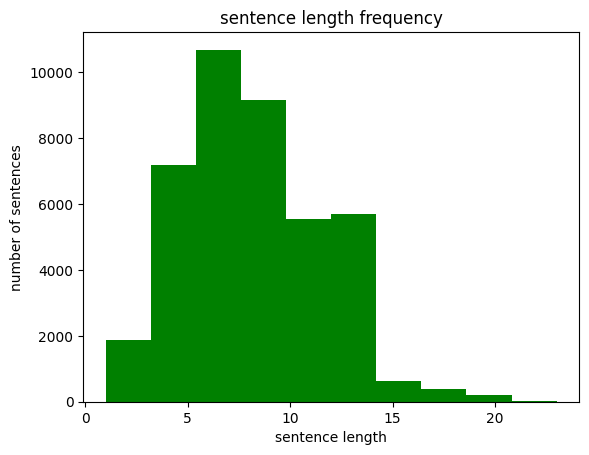

In [12]:
plt.hist([len(tokenizer.encode(text)) for text in text_title_list_final],color='g')
plt.title("sentence length frequency")
plt.ylabel("number of sentences")
plt.xlabel("sentence length")
plt.show()

In [13]:
max_seq = max([len(tokenizer.encode(text)) for text in text_title_list_final])

print(f'The longest text is {max_seq} tokens long.')
max_seq = 16

The longest text is 23 tokens long.


In [53]:
from datasets import Dataset

all_df = pd.DataFrame({'input': list(set(text_title_list_final)),"output" : list(set(text_title_list_final))})

train_df, val_df = train_test_split(all_df, test_size=0.05, shuffle=True, random_state=42)

train_data = Dataset.from_pandas(train_df)
val_data= Dataset.from_pandas(val_df)

In [15]:
import pandas as pd
from IPython.display import display, HTML

vision_data = pd.DataFrame({'images': images_list_final , 'output' : text_title_list_final})

nlp_data = pd.DataFrame({'input':list(set(text_title_list_final)),'output' : list(set(text_title_list_final))})

display(HTML(nlp_data[:10].to_html()))

,input,output
0,مزارع کلزا در خراسان شمالی,مزارع کلزا در خراسان شمالی
1,برداشت عسل در جم - بوشهر,برداشت عسل در جم - بوشهر
2,نشست تخصصی واکاوی عملیات ثامن‌الائمه (ع),نشست تخصصی واکاوی عملیات ثامن‌الائمه (ع)
3,اختتامیه نمایشگاه و همایش بین المللی خوشنویسی راه ابریشم,اختتامیه نمایشگاه و همایش بین المللی خوشنویسی راه ابریشم
4,پیاده روی زائران حرم مطهر امام رضا (ع),پیاده روی زائران حرم مطهر امام رضا (ع)
5,محله های تهران - شوش,محله های تهران - شوش
6,اینجا چراغی روشن است ...,اینجا چراغی روشن است ...
7,مواجهه با مرگ در شمایل بنر,مواجهه با مرگ در شمایل بنر
8,پایدار در روشنایی,پایدار در روشنایی
9,نماز عید قربان در حرم حضرت معصومه (س),نماز عید قربان در حرم حضرت معصومه (س)


In [16]:
# map article and summary len to dict as well as if sample is longer than 16 tokens
def map_to_length(x):
  x["out_len"] = len(tokenizer(x["output"]).input_ids)
  x["out_longer_16"] = int(x["out_len"] > 16)
  return x

In [17]:
train_data.info

DatasetInfo(description='', citation='', homepage='', license='', features={'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}, post_processed=None, supervised_keys=None, builder_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)

In [18]:
sample_size = 0.95 * len(images_list_final)
data_stats = train_data.select(range(1000)).map(map_to_length, num_proc=4)

In [19]:
def compute_and_print_stats(x):
  if len(x["out_len"]) == sample_size:
    print(
        "output Mean: {}, %-titles > 16:{}".format(
            sum(x["article_len"]) / sample_size,
            sum(x["article_longer_512"]) / sample_size, 
        )
    )

output = data_stats.map(
  compute_and_print_stats, 
  batched=True,
  batch_size=-1,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
output

Dataset(features: {'__index_level_0__': Value(dtype='int64', id=None), 'input': Value(dtype='string', id=None), 'out_len': Value(dtype='int64', id=None), 'out_longer_16': Value(dtype='int64', id=None), 'output': Value(dtype='string', id=None)}, num_rows: 1000)

In [21]:
encoder_max_length=max_seq
decoder_max_length=max_seq

def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["input"], padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer(batch["output"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  # because BERT automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`. 
  # We have to make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

In [54]:
batch_size=64

train_data = train_data.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["input", "output","__index_level_0__"]
)

val_data = val_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=16,
    remove_columns = ["input","output","__index_level_0__"]
)

  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [23]:
train_data

Dataset(features: {'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'decoder_attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'decoder_input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 1313)

In [55]:
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)


In [56]:
val_data.set_format(
    typt="torch" , columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

####Loading the nlp model

In [57]:
bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained(bert_name_or_path,gpt_name_or_path).float()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased-clf-persiannews were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at HooshvareLab/gpt2-fa and are newly initialized: ['transformer.h.7.crossattention.c_attn.weight', 'transformer.h.5.crossattention.c_proj.bias', 'transformer.h.2.crossattention.masked_bias', 'transformer.h.11.crossattention.q_attn.weight', 'transformer.h.8.crossattention.c_attn.weight', 'tran

In [58]:
bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
bert2bert.config.eos_token_id = tokenizer.eos_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id
bert2bert.config.vocab_size = bert2bert.config.encoder.vocab_size

In [59]:
bert2bert.config.max_length = 16
bert2bert.config.min_length = 2
bert2bert.config.no_repeat_ngram_size = 3
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 4

In [29]:
%%capture
!rm seq2seq_trainer.py
!rm seq2seq_training_args.py
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/seq2seq_trainer.py
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/seq2seq_training_args.py

In [30]:
%%capture
!pip install git-python==1.0.3
!pip install rouge_score
!pip install sacrebleu

In [31]:
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

In [32]:
!pip install --upgrade accelerate
!pip install transformers accelerate
!pip install git+https://github.com/huggingface/accelerate
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-jl9w91jc
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-jl9w91jc
  Resolved https://github.com/huggingface/accelerate to commit b9628f13c26944eee29ccf5d718352279963cc17
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=int(batch_size/4),
    fp16=True, 
    output_dir="/content/TasnimDataset/models",
    logging_steps=2,
    save_steps=5,
    eval_steps=4
)

In [34]:
import datasets

In [35]:
rouge = datasets.load_metric("rouge")

In [36]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [ ]:
!pip install numpy==1.23.4

In [ ]:
bert2bert.to(device)
trainer = Seq2SeqTrainer(
    model=bert2bert,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
4,0.494500,11.763989,0.000000,0.000000,0.000000
8,0.266900,12.910440,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no 

In [ ]:
!ls

In [ ]:
dummy_bert2bert = EncoderDecoderModel.from_pretrained("./checkpoint-20")

###using the models trained in the last section, now we will use Clip's vision part as our vision encoder

In [ ]:
import random
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('/content/gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("/content/gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
##set parsebert 

encoder = BertGenerationEncoder.from_pretrained("HooshvareLab/roberta-fa-zwnj-base", bos_token_id=101, eos_token_id=102)

decoder = BertGenerationDecoder.from_pretrained(
    "/content/gpt2", add_cross_attention=True, is_decoder=True, bos_token_id=101, eos_token_id=102
)

bert2bert = EncoderDecoderModel(encoder=encoder, decoder=decoder)

##set our handy tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

##a guide on how to use the model
loss = bert2bert(input_ids=input_ids, decoder_input_ids=labels, labels=labels).loss
loss.backward()

In [ ]:
from transformers import BertConfig, EncoderDecoderConfig, EncoderDecoderModel

# Initializing a BERT bert-base-uncased style configuration
config_encoder = BertConfig()
config_decoder = BertConfig()

config = EncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)

# Initializing a Bert2Bert model from the bert-base-uncased style configurations
model = EncoderDecoderModel(config=config)

# Accessing the model configuration
config_encoder = model.config.encoder
config_decoder = model.config.decoder
# set decoder config to causal lm
config_decoder.is_decoder = True
config_decoder.add_cross_attention = True

# Saving the model, including its configuration
model.save_pretrained("my-model")

# loading model and config from pretrained folder
encoder_decoder_config = EncoderDecoderConfig.from_pretrained("my-model")
model = EncoderDecoderModel.from_pretrained("my-model", config=encoder_decoder_config)

config_encoder = BertConfig("HooshvareLab/roberta-fa-zwnj-base")
config_decoder = BertConfig("/content/gpt2")

config = EncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)

# Initializing a Bert2Bert model from the bert-base-uncased style configurations
model = EncoderDecoderModel(config=config)

# Accessing the model configuration
config_encoder = model.config.encoder
config_decoder = model.config.decoder
# set decoder config to causal lm
config_decoder.is_decoder = True
config_decoder.add_cross_attention = True

# Saving the model, including its configuration
model.save_pretrained("my-model")

# loading model and config from pretrained folder
encoder_decoder_config = EncoderDecoderConfig.from_pretrained("my-model")
model = EncoderDecoderModel.from_pretrained("my-model", config=encoder_decoder_config)

In [30]:
epochs = 3
warmup_steps = 1e2
sample_every = 300

In [31]:
from transformers import AdamW

# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters.
optimizer = AdamW(
    model.parameters(),
    lr=5e-4,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)


In [35]:
tokenizer(texts[0])["input_ids"]
torch.tensor(tokenizer([texts[0]])["input_ids"])

tensor([[  272,  1486, 13048, 19968,   293,  2251,  4495]])

In [39]:
sample_text = texts[np.random.randint(0, len(texts))]
sample_input = f"<s>{sample_text}<|startoftext|>"
print(sample_input)
sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
sample_input_ids = sample_input_ids.to(device)

sample_outputs = model.generate(
    input_ids=sample_input_ids,
    # bos_token_id=random.randint(1, len(tokenizer.get_vocab())),
    do_sample=True,
    top_k=12,
    max_length=12,
    top_p=0.95,
    num_return_sequences=1
)
for i, sample_output in enumerate(sample_outputs):
    gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
    gen_sample_output = gen_sample_output.replace("<|startoftext|>", "\n")
    gen_sample_output = gen_sample_output.replace("<s>", "")
    gen_sample_output = gen_sample_output.replace("</s>", "")
    gen_sample_output = gen_sample_output.replace("<sep>", "\n")

    print(f'Example output: {gen_sample_output}')

<s>فینال لیگ برتر والیبال نشسته مردان<|startoftext|>
Example output: فینال لیگ برتر والیبال نشسته مردان
دین و بانوان


In [ ]:
import random
import time
import datetime
from tqdm import tqdm


def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in tqdm(range(0, epochs), position=0):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks, token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print()
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_poet = poets[np.random.randint(0, len(poets))]
            sample_input = f"<s>{sample_poet}<|startoftext|>"
            sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
            sample_input_ids = sample_input_ids.to(device)

            sample_outputs = model.generate(
                input_ids=sample_input_ids,
                # bos_token_id=random.randint(1, len(tokenizer.get_vocab())),
                do_sample=True,
                top_k=50,
                max_length=50,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
                gen_sample_output = gen_sample_output.replace("<|startoftext|>", "\n")
                gen_sample_output = gen_sample_output.replace("<s>", "")
                gen_sample_output = gen_sample_output.replace("</s>", "")
                gen_sample_output = gen_sample_output.replace("<sep>", "\n")

                print(f'Example output: {gen_sample_output}')

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print()
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader, total=len(validation_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print()
    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')
    print()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

In [ ]:
TEST_SIZE = 0.15
VALIDATION_SIZE = 0.15
BATCH_SIZE = 64

class CLIPDataset(Dataset):
    def __init__(self, list_image_path, list_txt):
        self.image_path = list_image_path
        self.text = my_tokenizer(list_txt).to(device)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        image = preprocess(Image.open(self.image_path[idx]))
        text = self.text[idx]
        return image, text

# class CLIPDataset(Dataset):
#     def __init__(self, images_path, list_txt):
#         self.images_path = images_path
#         # self.images = list_images.to(device)
#         self.text = my_tokenizer(list_txt).to(device)

#     def __len__(self):
#         return len(self.text)

#     def __getitem__(self, idx):
#         image = images[idx]
#         text = self.text[idx]
#         return image, text

all_df = pd.DataFrame({'text': text_title_list_final, 'image_path': images_list_final})

train_df, test_df = train_test_split(all_df, test_size=TEST_SIZE, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=VALIDATION_SIZE, shuffle=True, random_state=42)

train_dataset = CLIPDataset(train_df['image_path'].tolist(), train_df['text'].tolist())
test_dataset = CLIPDataset(test_df['image_path'].tolist(), test_df['text'].tolist())
val_dataset = CLIPDataset(val_df['image_path'].tolist(), val_df['text'].tolist())

dataloader = {}
dataloader['train'] = DataLoader(train_dataset, batch_size = BATCH_SIZE)
dataloader['test'] = DataLoader(test_dataset, batch_size = BATCH_SIZE)
dataloader['val'] = DataLoader(val_dataset, batch_size = BATCH_SIZE)

# Show shape of data
for phase in ['train', 'test', 'val']:
    for item in dataloader[phase]:
        print(f'[{phase}]')
        print(f'> item[0].shape: ', item[0].shape)
        print(f'> item[1].shape: ', item[1].shape)
        break

## Fine-tune model

<div style="direction:rtl;">در این بخش قصد داریم تا مدل ساخته شده را با استفاده از دیتاست مان Fine-tune کنیم.</div>

<div style="direction:rtl;">ابتدا لازم است تا یک سری از هایپرپارامترها را در این بخش تعیین کنیم:</div>
</br>

| Hyper-paremeter                                         | Value                                               |
| ------------------------------------------------------- | --------------------------------------------------- |
| Number of Epochs [EPOCH]                                |   10                                                |
| Learning-Rate [LR]                                      |   1e-7                                              |
| Eps for Adam-optimizer [EPS]                            |   1e-9                                              |
| Weight decay of Adam-optimizer [WEIGHT_DECAY]           |   0.1                                               |
| Maximum of learning-rate value for scheduler [MAX_LR]   |   1e-2                                              |
| Optimizer                                               |   Adam                                              |
| Learning-rate scheduler [scheduler]                     |   OneCycleLR                                        |
| Image and text prediction loss                          |   CrossEntropyLoss                                  |
| Number of freeze layers                                 |   20 layer of each module (visual and transformer)  |

In [ ]:
# !mkdir /content/drive/MyDrive/clip_trained_model

In [ ]:
EPOCH = 10
LR = 1e-3
EPS = 1e-9
WEIGHT_DECAY = 0.1
MAX_LR = 5e-3
MIN_LR = 1e-7
BASE_MODEL_PATH = '/content/drive/MyDrive/TasnimDataset/models/clip_trained_model/'

In [ ]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), 
                             lr=LR,
                             betas=(0.9,0.98),
                             eps=EPS,
                             weight_decay=WEIGHT_DECAY) 

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=MAX_LR, 
                                                steps_per_epoch=len(dataloader['train']), 
                                                epochs=EPOCH)

<div style="direction:rtl;">در این بخش مدل زبانی و مدل تصویر ۲۰ لایه آخر به حالت قابل آموزش هستند و بقیه مدل فریز شده است:</div>

In [ ]:
layer_num = [0, 0]
freeze_layer_thr = 30
freeze_layer_txt_thr = 20

for param in model.transformer.parameters():
    layer_num[0]+=1
for param in model.visual.parameters():
    layer_num[1]+=1

for i, param in enumerate(model.transformer.parameters()):
    if freeze_layer_txt_thr >= layer_num[0] - i:
        param.requires_grad = True
    else:
        param.requires_grad = False
for i, param in enumerate(model.visual.parameters()):
    if freeze_layer_thr >= layer_num[1] - i:
        param.requires_grad = True
    else:
        param.requires_grad = False



<div style="direction:rtl;">فرآیند آموزش به این شکل است که دارای دو فاز آموزش و اعتبار می باشد، در فاز آموزش گرادیان ها حساب شده و مراحل backpropagation انجام می شود ولی در فاز اعتبار صرفا بررسی می شود که مقدار loss چقدر است برای این داده ها، به نوعی برای مشخص کردن محلی است که مدل به اندازه کافی خوب شده است. که در این آموزش در ایپاک ۴ مدل خوب شده است.</div>

</br>

<div style="direction:rtl;">به منظور محاسبه loss در هنگام یادگیری، مطابق با <a href="https://arxiv.org/abs/2103.00020">مقاله CLIP</a> فرآیند انجام شده است:</div>

<br>

<p align="center"><img src="https://github.com/AAhmadS/NLP-HW3/blob/data/clip_train_loss.png?raw=1" width=60% /></p>

In [ ]:
def train_model(model, optimizer, scheduler, num_epochs=10):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        best_val_loss = 10000000 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            total_loss = 0.0
            num = 0

            with tqdm(dataloader[phase]) as pbar:
              for batch in pbar:
                optimizer.zero_grad()
                images, texts = batch
                images = images.to(device)
                texts = texts.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    logits_per_image, logits_per_text = model(images, texts)
                    ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
                    batch_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

                    if phase == 'train':
                        batch_loss.backward()
                        optimizer.step()

                total_loss += batch_loss
                num += 1
              if phase == 'train':
                  scheduler.step()

              epoch_loss = total_loss / num
              pbar.set_description(f'EPOCH:{epoch+1} - Loss: {epoch_loss/(i+1):.4f}')    

              
              if phase == 'val':
                if epoch_loss < best_val_loss:
                  best_val_loss = epoch_loss
                  torch.save(model.state_dict(), BASE_MODEL_PATH+f'clip_en_fi_ep.pt')

              print(f'{phase} Loss: {epoch_loss:.4f}')

              if phase == 'train':
                  torch.save(model.state_dict(), BASE_MODEL_PATH+f'clip_en_fi_ep{epoch}.pt')
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

In [ ]:
train_model(model=model, optimizer=optimizer, scheduler=scheduler, num_epochs=5)

Epoch 1/5
----------


  0%|          | 2/467 [00:17<1:08:41,  8.86s/it]


KeyboardInterrupt: ignored

In [ ]:

torch.save(model.state_dict(), f'clip_en_fi_ep{1}.pt')
          

##Adding the decoder to the model

In [ ]:
!pip install -q BertGeneration

In [ ]:
import BertGeneration
decoder = BertGenerationDecoder.from_pretrained(
    "bert-large-uncased", add_cross_attention=True, is_decoder=True, bos_token_id=101, eos_token_id=102
)

In [ ]:
##decoding loop

def train_model(model, optimizer, scheduler, num_epochs=5, criterion):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        best_val_loss = 10000000 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            total_loss = 0.0
            num = 0

            for batch in tqdm(dataloader[phase]):
                optimizer.zero_grad()
                images, texts = batch
                images = images.to(device)
                texts = texts.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(images)
                    ground_truth = texts
                    batch_loss = criterion(logits, ground_truth)

                    if phase == 'train':
                        batch_loss.backward()
                        optimizer.step()

                total_loss += batch_loss
                num += 1
            if phase == 'train':
                scheduler.step()

            epoch_loss = total_loss / num
            
            if phase == 'val':
              if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), BASE_MODEL_PATH+f'clip_en_fi_ep_dec.pt')

            print(f'{phase} Loss: {epoch_loss:.4f}')

            if phase == 'train':
                torch.save(model.state_dict(), BASE_MODEL_PATH+f'clip_en_fi_ep_dec{epoch}.pt')
            
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

In [ ]:
##suitable dataset based on latent vectors extracted from data

##todo 

##give all data latent vectors and save in the drive


## create the dataset, it should take vectors and text as input and output

In [ ]:
## parameters 

In [ ]:
##run

In [18]:
# from torch.utils.data import Dataset  # this is the pytorch class import
# import torch
# torch.manual_seed(42)


# class MTGDataset(Dataset):

#     def __init__(self, txt_list, tokenizer, max_length=1024):

#         self.tokenizer = tokenizer  # the gpt2 tokenizer we instantiated
#         self.input_ids = []
#         self.attn_masks = []

#         for txt in txt_list:
#             """
#             This loop will iterate through each entry in the flavour text corpus.
#             For each bit of text it will prepend it with the start of text token,
#             then append the end of text token and pad to the maximum length with the 
#             pad token. 
#             """

#             encodings_dict = tokenizer('<s>' + txt + '</s>',
#                                        truncation=True,
#                                        max_length=max_length,
#                                        padding="max_length")

#             """
#             Each iteration then appends either the encoded tensor to a list,
#             or the attention mask for that encoding to a list. The attention mask is
#             a binary list of 1's or 0's which determine whether the langauge model
#             should take that token into consideration or not. 
#             """
#             self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
#             self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

#     def __len__(self):
#         return len(self.input_ids)

#     def __getitem__(self, idx):
#         return self.input_ids[idx], self.attn_masks[idx]

In [21]:
# from torch.utils.data import random_split

# texts = list(set(text_title_list_final))

# dataset = MTGDataset(texts, tokenizer, max_length=max_seq)

# # Split into training and validation sets
# train_size = int(0.95 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# f'There are {len(train_dataset)} samples for training, and {len(val_dataset)} samples for validation testing'

'There are 1313 samples for training, and 70 samples for validation testing'

In [22]:
# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# train_dataloader = DataLoader(
#     train_dataset,
#     sampler=RandomSampler(train_dataset),
#     batch_size=8
# )

# validation_dataloader = DataLoader(
#     val_dataset,
#     sampler=SequentialSampler(val_dataset),
#     batch_size=8
# )

In [23]:
# len(tokenizer)

42001